In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import pystan
import seaborn as sns
import arviz
%matplotlib inline

In [3]:
df = pd.read_excel("../../data/data_covid_fix_name.xlsx")
df = df.dropna().reset_index(drop=True)

In [4]:
df.head()

,country,pop,urb,gdp,dist,hf,pf,ef,date_first,detection,status,cumul,air
0,Albania,2866376,60.319,13364.155397,6.996524e+06,7.84,8.005411,7.67,70,74.3,1,108641,303.14
1,Algeria,42228429,72.629,15481.787620,9.108277e+06,4.99,5.201489,4.77,58,12.0,1,80272,6442.44
2,Angola,30809762,65.514,6452.355165,1.049012e+07,5.40,5.979936,4.83,83,17.9,1,303691,76.94
3,Argentina,44494502,91.870,20610.568550,1.902562e+07,6.86,8.044600,5.67,65,74.9,1,92122,1516.63
4,Australia,24992369,86.012,51663.365095,7.608913e+06,8.62,9.160533,8.07,26,97.3,1,1347,75667.65


# 階層ベイズモデル

In [5]:
# 必要な変数の抽出
X = df[["date_first", "hf", "pop", "urb", "dist", "air"]]
# 全て対数化
X = np.log(X)
# indexを追加(国ごとの差を表現するindex)
X = X.reset_index()
X["index"] = X["index"] +1

X.head()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,index,date_first,hf,pop,urb,dist,air
0,1,4.248495,2.059239,14.868559,4.099647,15.760924,5.714195
1,2,4.060443,1.607436,17.558604,4.285364,16.024694,8.770663
2,3,4.418841,1.686399,17.243342,4.182264,16.165944,4.343026
3,4,4.174387,1.925707,17.610876,4.520375,16.761297,7.324246
4,5,3.258097,2.154085,17.034081,4.454487,15.844831,11.234106


In [6]:
X["index"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150])

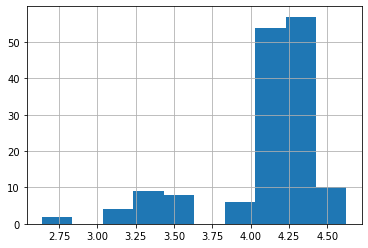

In [11]:
X["date_first"].hist()

In [13]:
print("平均：",X["date_first"].mean())
print("分散：",X["date_first"].std())

平均： 4.0961478534307325
分散： 0.3802198509854085


In [58]:
# 正規分布を仮定
stan_model = """
data {
    int N;
    int N_country;
    vector[N] hf;
    vector[N] pop;
    vector[N] urb;
    vector[N] dist;
    vector[N] air;
    vector[N] Y;
    vector[N] Y_new;
}

parameters {

    real<lower=0> s_k; 
    vector[N] k;
    
    real h;
    real p;
    real u;
    real d;
    real a;
    real b;
    real<lower=0> sigma; 
}

transformed parameters{
    vector[N] mu = b + h * hf + p * pop + u * urb + d * dist + a * air + k;
}


model{
    k ~ normal(0, s_k);
    Y ~ normal(mu, sigma);
}

generated quantities {
    Y_new = normal_rng(b + h * hf + p * pop + u * urb + d * dist + a * air + k, sigma);
}

"""

In [59]:
sm = pystan.StanModel(model_code = stan_model)

ValueError: Failed to parse Stan model 'anon_model_5b10df7b179755cb25c91cb08edba4f2'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:
Cannot assign to variable outside of declaration block; left-hand-side variable origin=data
Illegal statement beginning with non-void expression parsed as
  Y_new
Not a legal assignment, sampling, or function statement.  Note that
  * Assignment statements only allow variables (with optional indexes) on the left;
  * Sampling statements allow arbitrary value-denoting expressions on the left.
  * Functions used as statements must be declared to have void returns

 error in 'unknown file name' at line 39, column 4
  -------------------------------------------------
    37: 
    38: generated quantities {
    39:     Y_new = normal_rng(b + h * hf + p * pop + u * urb + d * dist + a * air + k, sigma);
           ^
    40: }
  -------------------------------------------------

PARSER EXPECTED: <one of the following:
  a variable declaration, beginning with type
      (int, real, vector, row_vector, matrix, unit_vector,
       simplex, ordered, positive_ordered,
       corr_matrix, cov_matrix,
       cholesky_corr, cholesky_cov
  or a <statement>
  or '}' to close variable declarations and definitions>


In [39]:
sm

In [40]:
stan_data = {
    "N":X.shape[0],
    "N_country":X.shape[0],
    "hf":X["hf"],
    "pop":X["pop"],
    "urb":X["urb"],
    "dist":X["dist"],
    "air":X["air"],
    "Y":X["date_first"],
    "index":X["index"],
    "N_new":X.shape[0],
}

In [41]:
fit = sm.sampling(data=stan_data, iter=2000, warmup=600, chains=3, seed=123)

In [42]:
print(fit)

Inference for Stan model: anon_model_94a98d07767ed4649c09445c0208bf40.
3 chains, each with iter=2000; warmup=600; thin=1; 
post-warmup draws per chain=1400, total post-warmup draws=4200.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
s_k       0.15    0.02   0.07   0.03   0.09   0.17   0.21   0.26     17   1.22
k[1]      0.04  3.5e-3   0.11  -0.19  -0.03   0.03   0.11   0.28   1063   1.01
k[2]     -0.06  6.6e-3   0.12  -0.31  -0.13  -0.04   0.02   0.17    336   1.01
k[3]      0.02  1.9e-3   0.11   -0.2  -0.0410.0e-3   0.08   0.25   3328    1.0
k[4]    3.3e-3  1.9e-3   0.11  -0.22  -0.06 3.1e-3   0.07   0.25   3556    1.0
k[5]     -0.18    0.02   0.17  -0.53   -0.3  -0.15  -0.04   0.08     49   1.08
k[6]      0.07  8.2e-3   0.12  -0.14  -0.01   0.05   0.14   0.33    203   1.02
k[7]      0.01  1.7e-3   0.11  -0.21  -0.05 6.2e-3   0.07   0.24   3916    1.0
k[8]   -9.8e-3  1.8e-3   0.11  -0.24  -0.07-6.6e-3   0.06   0.22   3644    1.0
k[9]     -0.03  3.6e-3

In [43]:
"""with open('output1027.txt', 'w') as f:
    print(fit, file=f)"""

"with open('output1027.txt', 'w') as f:\n    print(fit, file=f)"

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/arviz/plots/traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (308), generating only 20 plots
  UserWarning,


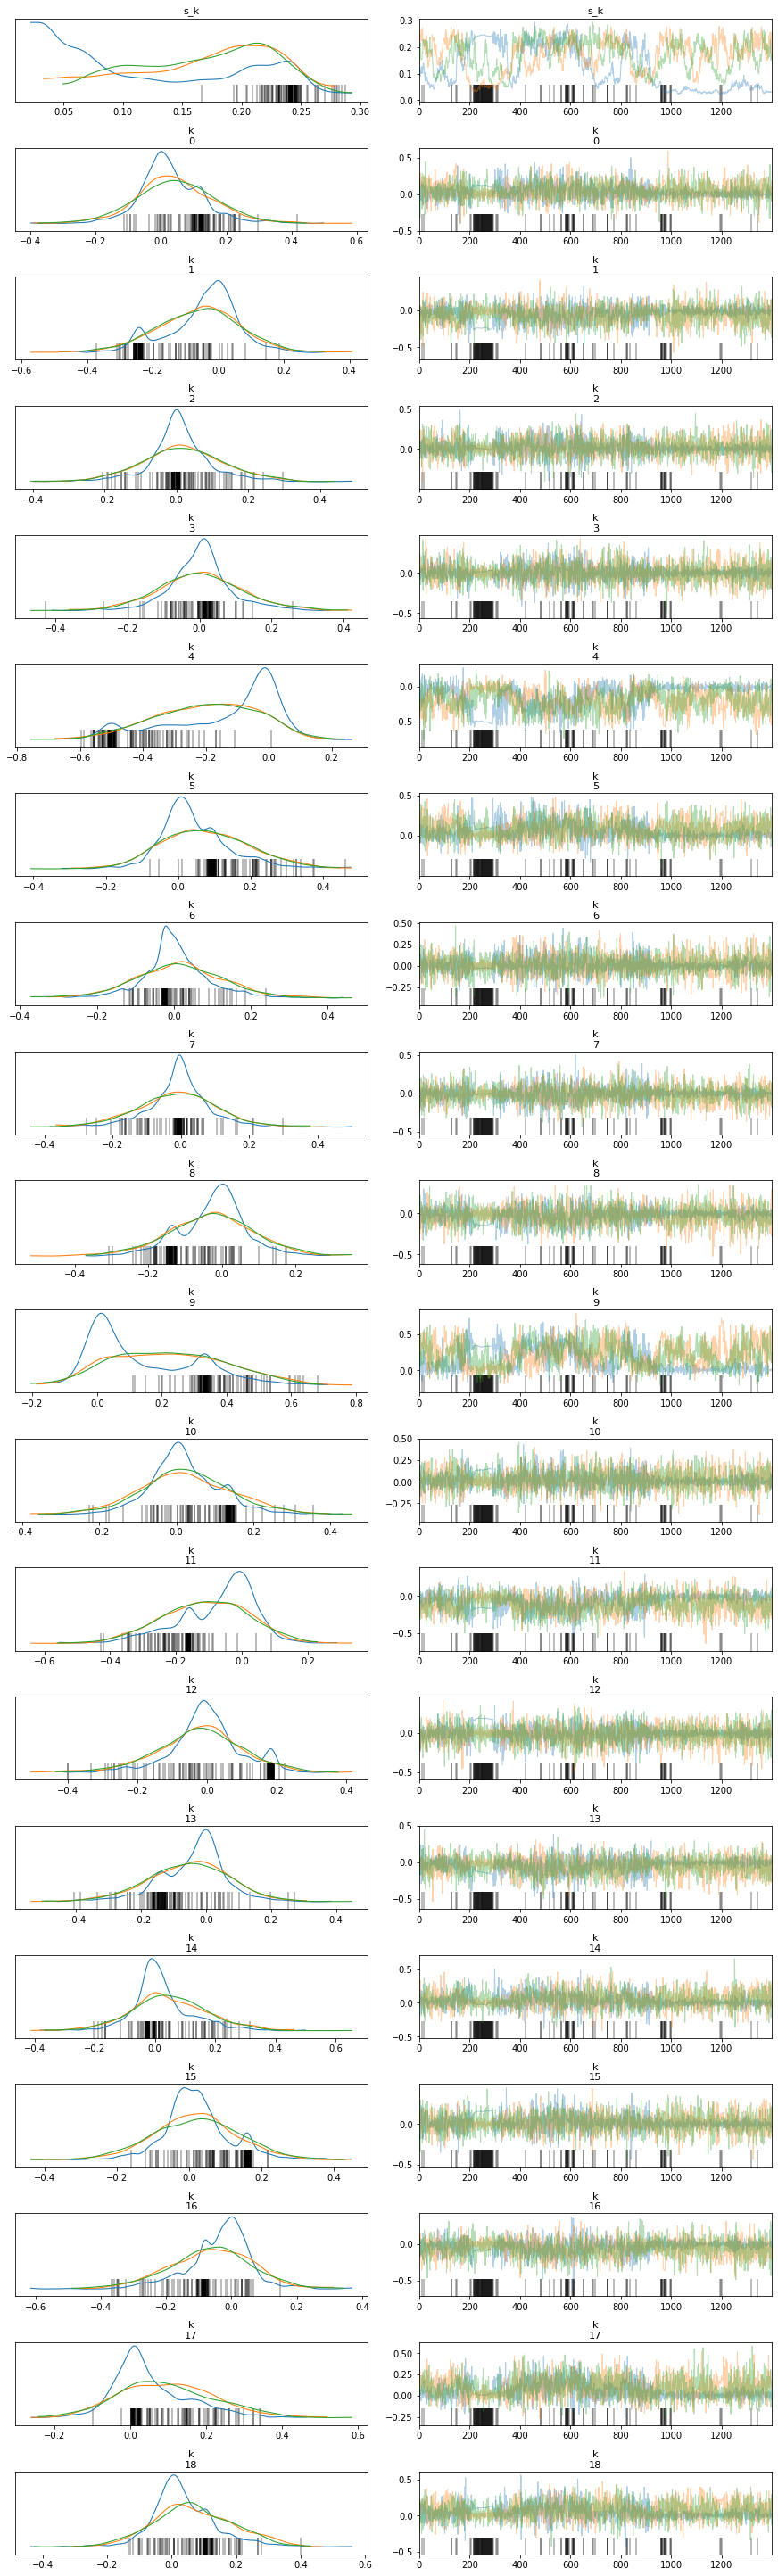

In [44]:
arviz.plot_trace(fit)
plt.show()

In [45]:
"""axes = arviz.plot_trace(fit)
fig = axes.ravel()[0].figure
fig.savefig("bayes1027.png")"""

'axes = arviz.plot_trace(fit)\nfig = axes.ravel()[0].figure\nfig.savefig("bayes1027.png")'

- mersのデータと比較(説明変数の影響度の)    
- うまい結果が出れば、国ごとの個性を活用。クラスタリング    
- pymc、データから自動的にアルゴリズムが選ばれる??  
  
  
- 背景知識  
- ドメイン、ウイルスの流行、COVID-19  
- 過去のウイルス(過去のことで何がわかっているか、covid19と比較) 
- 平均